# Paper Benchmarking: Cross-Framework Rigor and Performance

This notebook provides a paper-ready benchmarking template:
- Compare VAMOS with pymoo, jMetalPy, Platypus, and DEAP on ZDT/DTLZ/WFG with identical budgets.
- Report HV and IGD, plus Friedman test and post-hoc pairwise Wilcoxon.
- Benchmark vectorized vs baseline evaluation and VAMOS backends (NumPy/Numba/MooCore).
- Record hardware details for reproducibility.

Notes:
- Defaults are small for interactive runs; increase budgets and seeds for a paper.
- Missing optional dependencies are skipped automatically.


## Optional dependencies

Recommended extras:
- pip install -e ".[backends,benchmarks,notebooks]"
- pip install pymoo jmetalpy platypus-opt deap


In [1]:
import os
import sys
import time
import random
import platform
import json
import io
from contextlib import redirect_stdout
import importlib.metadata as im

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vamos import optimize, OptimizeConfig, NSGAIIConfig, ZDT1, DTLZ2, WFG4
from vamos.foundation.metrics.hv_zdt import get_zdt_reference_front
from vamos.foundation.metrics.hypervolume import compute_hypervolume
from vamos.ux.analysis.stats import friedman_test, pairwise_wilcoxon, plot_critical_distance
from vamos.foundation.kernel.registry import KERNELS, resolve_kernel

plt.style.use("ggplot")

# Paper-ready styling
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.figsize": (6, 4),
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
})


In [2]:
try:
    import psutil
    HAS_PSUTIL = True
except Exception:
    psutil = None
    HAS_PSUTIL = False

def get_hardware_info():
    info = {
        "platform": platform.platform(),
        "processor": platform.processor(),
        "cpu_count": os.cpu_count(),
        "python": sys.version.split()[0],
    }
    if HAS_PSUTIL:
        info["memory_gb"] = round(psutil.virtual_memory().total / 1e9, 2)
        info["rss_mb"] = round(psutil.Process(os.getpid()).memory_info().rss / (1024 ** 2), 2)
    else:
        info["memory_gb"] = None
        info["rss_mb"] = None
    return info

hardware = get_hardware_info()

# Git metadata
try:
    import subprocess
    git_commit = subprocess.check_output(["git", "rev-parse", "--short", "HEAD"]).decode("ascii").strip()
    git_status = subprocess.check_output(["git", "status", "--porcelain"]).decode("ascii").strip()
    is_dirty = bool(git_status)
    hardware["git_commit"] = git_commit
    hardware["git_dirty"] = is_dirty
except Exception:
    hardware["git_commit"] = "unknown"
    hardware["git_dirty"] = "unknown"
pd.DataFrame([hardware])


,platform,processor,cpu_count,python,memory_gb,rss_mb
0,Windows-11-10.0.26200-SP0,"Intel64 Family 6 Model 170 Stepping 4, Genuine...",22,3.12.3,33.88,183.77


## Reproducibility metadata

Capture package versions and math library config for the paper appendix.


In [3]:
def package_version(name):
    try:
        return im.version(name)
    except Exception:
        return None

packages = [
    "vamos",
    "numpy",
    "scipy",
    "numba",
    "moocore",
    "pymoo",
    "jmetalpy",
    "platypus-opt",
    "deap",
    "pandas",
    "matplotlib",
]
versions = {pkg: package_version(pkg) for pkg in packages}

env_vars = {
    "OMP_NUM_THREADS": os.environ.get("OMP_NUM_THREADS"),
    "MKL_NUM_THREADS": os.environ.get("MKL_NUM_THREADS"),
    "OPENBLAS_NUM_THREADS": os.environ.get("OPENBLAS_NUM_THREADS"),
    "NUMEXPR_NUM_THREADS": os.environ.get("NUMEXPR_NUM_THREADS"),
    "NUMBA_NUM_THREADS": os.environ.get("NUMBA_NUM_THREADS"),
}

buf = io.StringIO()
with redirect_stdout(buf):
    np.__config__.show()
np_config = buf.getvalue()

versions_df = pd.DataFrame.from_dict(versions, orient="index", columns=["version"])
env_df = pd.DataFrame([env_vars])

versions_df
env_df
print(np_config)


{
  "Compilers": {
    "c": {
      "name": "msvc",
      "linker": "link",
      "version": "19.44.35219",
      "commands": "cl"
    },
    "cython": {
      "name": "cython",
      "linker": "cython",
      "version": "3.2.1",
      "commands": "cython"
    },
    "c++": {
      "name": "msvc",
      "linker": "link",
      "version": "19.44.35219",
      "commands": "cl"
    }
  },
  "Machine Information": {
    "host": {
      "cpu": "x86_64",
      "family": "x86_64",
      "endian": "little",
      "system": "windows"
    },
    "build": {
      "cpu": "x86_64",
      "family": "x86_64",
      "endian": "little",
      "system": "windows"
    }
  },
  "Build Dependencies": {
    "blas": {
      "name": "scipy-openblas",
      "found": true,
      "version": "0.3.30",
      "detection method": "pkgconfig",
      "include directory": "C:/Users/runneradmin/AppData/Local/Temp/cibw-run-q7k2ejt3/cp312-win_amd64/build/venv/Lib/site-packages/scipy_openblas64/include",
      "lib directo

c:\Users\nicor\Desktop\VAMOS\.venv\Lib\site-packages\numpy\__config__.py:155: UserWarning: Install `pyyaml` for better output
  warnings.warn("Install `pyyaml` for better output", stacklevel=1)


## Benchmark configuration


In [4]:
POP_SIZE = 100
MAX_EVALS = 10000
SEEDS = [1, 2, 3, 4, 5]

COMPARISON_MODE = "matched"  # "native_defaults" where supported

RUN_QOT = True
QOT_BUDGETS = [0.25, 0.5, 1.0]
QOT_SEEDS = [1]

RUN_SCALING = True
SCALING_FRAMEWORKS = ["vamos"]
SCALING_POP_SIZES = [50, 100, 200]
SCALING_N_VARS = [30, 60, 100]
SCALING_N_OBJS = [2, 3, 5]
SCALING_MAX_EVALS = 4000
SCALING_SEED = 1

PROBLEMS = [
    {"key": "zdt1", "label": "ZDT1", "n_var": 30, "n_obj": 2},
    {"key": "dtlz2", "label": "DTLZ2", "n_var": 12, "n_obj": 2},
    {"key": "wfg4", "label": "WFG4", "n_var": 24, "n_obj": 2},
]

FRAMEWORKS = ["vamos", "pymoo", "jmetalpy", "platypus", "deap"]


In [5]:
def module_available(name):
    try:
        __import__(name)
        return True
    except Exception:
        return False

HAS_PYMOO = module_available("pymoo")
HAS_JMETAL = module_available("jmetal")
HAS_PLATYPUS = module_available("platypus")
HAS_DEAP = module_available("deap")

availability = {
    "pymoo": HAS_PYMOO,
    "jmetalpy": HAS_JMETAL,
    "platypus": HAS_PLATYPUS,
    "deap": HAS_DEAP,
}
pd.DataFrame([availability])


,pymoo,jmetalpy,platypus,deap
0,True,True,True,True


## Reference fronts and metrics


In [6]:
def wfg_params(spec):
    n_var = spec["n_var"]
    n_obj = spec["n_obj"]
    k = max(4, 2 * (n_obj - 1))
    l = n_var - k
    if l < 1:
        raise ValueError(
            f"WFG requires n_var >= k+1 (got n_var={n_var}, k={k})."
        )
    return k, l

def make_vamos_problem(spec):
    if spec["key"] == "zdt1":
        return ZDT1(n_var=spec["n_var"])
    if spec["key"] == "dtlz2":
        return DTLZ2(n_var=spec["n_var"], n_obj=spec["n_obj"])
    if spec["key"] == "wfg4":
        try:
            k, l = wfg_params(spec)
            return WFG4(n_var=spec["n_var"], n_obj=spec["n_obj"], k=k, l=l)
        except ImportError as exc:
            print(f"WFG requires pymoo: {exc}")
            return None
        except ValueError as exc:
            print(f"Invalid WFG parameters: {exc}")
            return None
    raise ValueError(f"Unknown problem {spec['key']}")


In [7]:
def pareto_front_2d(F):
    if F.size == 0:
        return F
    idx = np.argsort(F[:, 0])
    F_sorted = F[idx]
    front = []
    best_f2 = np.inf
    for f1, f2 in F_sorted:
        if f2 < best_f2:
            front.append([f1, f2])
            best_f2 = f2
    return np.asarray(front, dtype=float)

def sample_reference_front(spec, n_samples=5000, seed=123):
    problem = make_vamos_problem(spec)
    if problem is None:
        return None
    rng = np.random.default_rng(seed)
    X = rng.uniform(problem.xl, problem.xu, size=(n_samples, problem.n_var))
    F = np.empty((n_samples, problem.n_obj))
    problem.evaluate(X, {"F": F})
    return pareto_front_2d(F)

def reference_front(spec, n_points=1000):
    key = spec["key"]
    if key.startswith("zdt"):
        return get_zdt_reference_front(key, n_points)
    if key == "dtlz2":
        theta = np.linspace(0.0, np.pi / 2.0, n_points)
        return np.column_stack([np.cos(theta), np.sin(theta)])
    if key.startswith("wfg"):
        if HAS_PYMOO:
            try:
                from pymoo.problems import get_problem
                k, l = wfg_params(spec)
                prob = get_problem(
                    key,
                    n_var=spec["n_var"],
                    n_obj=spec["n_obj"],
                    k=k,
                    l=l,
                )
                pf = prob.pareto_front(n_points)
                if pf is not None:
                    return np.asarray(pf, dtype=float)
            except Exception as exc:
                print(f"pymoo pareto_front failed for {key}: {exc}")
        return sample_reference_front(spec, n_samples=max(5000, n_points))
    raise ValueError(f"No reference front for {key}")


In [8]:
REF_FRONTS = {}
for spec in PROBLEMS:
    ref = reference_front(spec)
    if ref is None or len(ref) == 0:
        print(f"Skipping {spec['label']} (no reference front).")
        continue
    REF_FRONTS[spec["key"]] = ref

list(REF_FRONTS.keys())


pymoo pareto_front failed for wfg4: a bytes-like object is required, not 'int'


['zdt1', 'dtlz2', 'wfg4']

In [9]:
try:
    from vamos.foundation.metrics import moocore_indicators as mi
    HAS_MOOCORE = mi.has_moocore()
except Exception:
    mi = None
    HAS_MOOCORE = False

def hv_reference_point(F, ref_front):
    worst = np.maximum(np.max(F, axis=0), np.max(ref_front, axis=0))
    margin = 0.1 * np.maximum(1.0, np.abs(worst))
    return worst + margin

def igd(F, ref_front):
    F = np.asarray(F, dtype=float)
    ref = np.asarray(ref_front, dtype=float)
    if F.size == 0 or ref.size == 0:
        return np.nan
    diff = ref[:, None, :] - F[None, :, :]
    dist = np.linalg.norm(diff, axis=2)
    return float(np.mean(np.min(dist, axis=1)))

def igd_plus(F, ref_front):
    F = np.asarray(F, dtype=float)
    ref = np.asarray(ref_front, dtype=float)
    if F.size == 0 or ref.size == 0:
        return np.nan
    diff = F[None, :, :] - ref[:, None, :]
    diff = np.maximum(diff, 0.0)
    dist = np.linalg.norm(diff, axis=2)
    return float(np.mean(np.min(dist, axis=1)))

def epsilon_additive(F, ref_front):
    F = np.asarray(F, dtype=float)
    ref = np.asarray(ref_front, dtype=float)
    if F.size == 0 or ref.size == 0:
        return np.nan
    diff = F[None, :, :] - ref[:, None, :]
    eps = np.max(diff, axis=2)
    min_eps = np.min(eps, axis=1)
    return float(np.max(min_eps))

def compute_metrics(F, ref_front):
    metrics = {
        "hv": np.nan,
        "hv_norm": np.nan,
        "igd": np.nan,
        "igd_plus": np.nan,
        "epsilon_add": np.nan,
    }
    if F is None or len(F) == 0:
        return metrics
    F = np.asarray(F, dtype=float)
    ref_front = np.asarray(ref_front, dtype=float)
    if ref_front.size == 0:
        return metrics

    igd_val = igd(F, ref_front)
    igd_plus_val = igd_plus(F, ref_front)
    eps_add = epsilon_additive(F, ref_front)

    if HAS_MOOCORE:
        try:
            igd_plus_val = float(mi.IGDPlusIndicator(reference_front=ref_front).compute(F).value)
        except Exception:
            pass
        try:
            eps_add = float(mi.EpsilonAdditiveIndicator(reference_front=ref_front).compute(F).value)
        except Exception:
            pass

    hv = np.nan
    hv_norm = np.nan
    if F.shape[1] == 2:
        ref_point = hv_reference_point(F, ref_front)
        hv = compute_hypervolume(F, ref_point)
        hv_ref = compute_hypervolume(ref_front, ref_point) if len(ref_front) else np.nan
        hv_norm = hv / hv_ref if hv_ref and hv_ref > 0 else np.nan

    metrics.update(
        {
            "hv": hv,
            "hv_norm": hv_norm,
            "igd": igd_val,
            "igd_plus": igd_plus_val,
            "epsilon_add": eps_add,
        }
    )
    return metrics


## Framework adapters


In [10]:
import tracemalloc

def run_with_profile(fn, *args, **kwargs):
    proc = psutil.Process(os.getpid()) if HAS_PSUTIL else None
    rss_before = proc.memory_info().rss / (1024 ** 2) if proc else np.nan
    cpu_before = time.process_time()
    tracemalloc.start()
    start = time.perf_counter()
    result = fn(*args, **kwargs)
    elapsed = time.perf_counter() - start
    cpu_time = time.process_time() - cpu_before
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    rss_after = proc.memory_info().rss / (1024 ** 2) if proc else np.nan
    rss_delta = rss_after - rss_before if proc else np.nan
    return result, elapsed, peak / (1024 ** 2), cpu_time, rss_after, rss_delta

def run_vamos(spec, seed, engine="numpy", max_evals=None, pop_size=None):
    problem = make_vamos_problem(spec)
    if problem is None:
        return None
    max_evals = max_evals or MAX_EVALS
    pop_size = pop_size or POP_SIZE
    cfg = NSGAIIConfig.default(pop_size=pop_size, n_var=problem.n_var, engine=engine)
    result = optimize(
        OptimizeConfig(
            problem=problem,
            algorithm="nsgaii",
            algorithm_config=cfg,
            termination=("n_eval", max_evals),
            seed=seed,
            engine=engine,
        )
    )
    return np.asarray(result.F, dtype=float)

def run_pymoo(spec, seed, max_evals=None, pop_size=None):
    if not HAS_PYMOO:
        return None
    from pymoo.algorithms.moo.nsga2 import NSGA2
    from pymoo.operators.crossover.sbx import SBX
    from pymoo.operators.mutation.pm import PM
    from pymoo.operators.sampling.rnd import FloatRandomSampling
    from pymoo.optimize import minimize
    from pymoo.problems import get_problem

    max_evals = max_evals or MAX_EVALS
    pop_size = pop_size or POP_SIZE

    key = spec["key"]
    if key.startswith("zdt"):
        problem = get_problem(key, n_var=spec["n_var"])
    elif key.startswith("dtlz"):
        problem = get_problem(key, n_var=spec["n_var"], n_obj=spec["n_obj"])
    elif key.startswith("wfg"):
        try:
            k, l = wfg_params(spec)
        except ValueError as exc:
            print(f"Invalid WFG parameters: {exc}")
            return None
        problem = get_problem(key, n_var=spec["n_var"], n_obj=spec["n_obj"], k=k, l=l)
    else:
        return None

    if COMPARISON_MODE == "native_defaults":
        algorithm = NSGA2(pop_size=pop_size)
    else:
        algorithm = NSGA2(
            pop_size=pop_size,
            sampling=FloatRandomSampling(),
            crossover=SBX(prob=0.9, eta=20.0),
            mutation=PM(prob=1.0 / spec["n_var"], eta=20.0),
            eliminate_duplicates=True,
        )
    res = minimize(problem, algorithm, ("n_eval", max_evals), seed=seed, verbose=False)
    return np.asarray(res.F, dtype=float)

def run_jmetalpy(spec, seed, max_evals=None, pop_size=None):
    if not HAS_JMETAL:
        return None
    try:
        from jmetal.algorithm.multiobjective.nsgaii import NSGAII
        from jmetal.operator.crossover import SBXCrossover
        from jmetal.operator.mutation import PolynomialMutation
        from jmetal.util.termination_criterion import StoppingByEvaluations
    except Exception:
        return None

    max_evals = max_evals or MAX_EVALS
    pop_size = pop_size or POP_SIZE

    # Set seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    key = spec["key"]
    if key == "zdt1":
        from jmetal.problem.multiobjective.zdt import ZDT1
        problem = ZDT1(number_of_variables=spec["n_var"])
    elif key == "dtlz2":
        from jmetal.problem.multiobjective.dtlz import DTLZ2
        problem = DTLZ2(number_of_variables=spec["n_var"], number_of_objectives=spec["n_obj"])
    elif key == "wfg4":
        try:
            from jmetal.problem.multiobjective.wfg import WFG4
            try:
                k, _ = wfg_params(spec)
            except ValueError as exc:
                print(f"Invalid WFG parameters: {exc}")
                return None
            try:
                problem = WFG4(
                    number_of_variables=spec["n_var"],
                    number_of_objectives=spec["n_obj"],
                    k=k,
                )
            except TypeError:
                problem = WFG4(
                    number_of_variables=spec["n_var"],
                    number_of_objectives=spec["n_obj"],
                )
        except Exception:
            return None
    else:
        return None

    algorithm = NSGAII(
        problem=problem,
        population_size=pop_size,
        offspring_population_size=pop_size,
        mutation=PolynomialMutation(probability=1.0 / spec["n_var"], distribution_index=20.0),
        crossover=SBXCrossover(probability=0.9, distribution_index=20.0),
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evals),
    )
    algorithm.run()
    get_result_fn = getattr(algorithm, "result", None)
    solutions = get_result_fn() if callable(get_result_fn) else []
    F = np.array([sol.objectives for sol in solutions], dtype=float)
    return F

def run_platypus(spec, seed, max_evals=None, pop_size=None):
    if not HAS_PLATYPUS:
        return None
    try:
        from platypus import NSGAII, Problem, Real
    except Exception:
        return None

    max_evals = max_evals or MAX_EVALS
    pop_size = pop_size or POP_SIZE

    random.seed(seed)
    problem = make_vamos_problem(spec)
    if problem is None:
        return None

    plat_prob = Problem(problem.n_var, problem.n_obj)
    plat_prob.types[:] = [Real(problem.xl, problem.xu) for _ in range(problem.n_var)]

    def eval_fn(vars):
        X = np.asarray(vars, dtype=float)[None, :]
        F = np.empty((1, problem.n_obj))
        problem.evaluate(X, {"F": F})
        return F[0].tolist()

    plat_prob.function = eval_fn
    algorithm = NSGAII(plat_prob, population_size=pop_size)
    algorithm.run(max_evals)
    F = np.asarray([s.objectives for s in algorithm.result], dtype=float)
    return F

def run_deap(spec, seed, max_evals=None, pop_size=None):
    if not HAS_DEAP:
        return None
    from deap import base, creator, tools

    max_evals = max_evals or MAX_EVALS
    pop_size = pop_size or POP_SIZE

    problem = make_vamos_problem(spec)
    if problem is None:
        return None

    random.seed(seed)
    np.random.seed(seed)

    n_obj = problem.n_obj
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=tuple([-1.0] * n_obj))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, problem.xl, problem.xu)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=problem.n_var)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def eval_ind(ind):
        X = np.asarray(ind, dtype=float)[None, :]
        F = np.empty((1, problem.n_obj))
        problem.evaluate(X, {"F": F})
        return tuple(F[0])

    toolbox.register("evaluate", eval_ind)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=problem.xl, up=problem.xu, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=problem.xl, up=problem.xu, eta=20.0, indpb=1.0 / problem.n_var)
    toolbox.register("select", tools.selNSGA2)

    pop = toolbox.population(n=pop_size)
    invalid = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid)
    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    n_gen = max(1, max_evals // pop_size)
    for _ in range(1, n_gen):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= 0.9:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values, ind2.fitness.values

        for mutant in offspring:
            if random.random() <= 1.0:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid)
        for ind, fit in zip(invalid, fitnesses):
            ind.fitness.values = fit

        pop = toolbox.select(pop + offspring, pop_size)

    F = np.asarray([ind.fitness.values for ind in pop], dtype=float)
    return F

RUNNERS = {
    "vamos": run_vamos,
    "pymoo": run_pymoo,
    "jmetalpy": run_jmetalpy,
    "platypus": run_platypus,
    "deap": run_deap,
}


## Run benchmarks


In [11]:
results = []
attempts = []
failures = []
for spec in PROBLEMS:
    if spec["key"] not in REF_FRONTS:
        continue
    ref = REF_FRONTS[spec["key"]]
    for framework in FRAMEWORKS:
        runner = RUNNERS.get(framework)
        if runner is None:
            continue
        for seed in SEEDS:
            attempts.append({"framework": framework, "problem": spec["label"], "seed": seed})
            try:
                F, elapsed, peak, cpu_time, rss_mb, rss_delta = run_with_profile(
                    runner,
                    spec,
                    seed,
                    max_evals=MAX_EVALS,
                    pop_size=POP_SIZE,
                )
            except Exception as exc:
                failures.append(
                    {
                        "framework": framework,
                        "problem": spec["label"],
                        "seed": seed,
                        "error": str(exc),
                    }
                )
                print(f"Skipping {framework} {spec['label']} seed {seed}: {exc}")
                continue
            if F is None or len(F) == 0:
                continue
            metrics = compute_metrics(F, ref)
            n_eval = MAX_EVALS
            if framework == "deap":
                n_eval = (MAX_EVALS // POP_SIZE) * POP_SIZE
            results.append(
                {
                    "framework": framework,
                    "problem": spec["label"],
                    "seed": seed,
                    "n_eval": n_eval,
                    "max_evals": MAX_EVALS,
                    "hv": metrics["hv"],
                    "hv_norm": metrics["hv_norm"],
                    "igd": metrics["igd"],
                    "igd_plus": metrics["igd_plus"],
                    "epsilon_add": metrics["epsilon_add"],
                    "time_s": elapsed,
                    "cpu_time_s": cpu_time,
                    "mem_mb": peak,
                    "rss_mb": rss_mb,
                    "rss_mb_delta": rss_delta,
                    "n_points": len(F),
                    "pop_size": POP_SIZE,
                    "n_var": spec["n_var"],
                    "n_obj": spec["n_obj"],
                    "comparison_mode": COMPARISON_MODE,
                }
            )

results_df = pd.DataFrame(results)
results_df.head()


[2025-12-23 20:47:00,523] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-23 20:47:00,530] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-12-23 20:47:00,532] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-12-23 20:47:00,533] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-12-23 20:47:10,214] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-12-23 20:47:10,225] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-23 20:47:10,231] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-12-23 20:47:10,235] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-12-23 20:47:10,238] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-12-23 20:47:22,749] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-12-23 20:47:22,768] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-23 20:47:22,776] [jm

,framework,problem,seed,n_eval,max_evals,hv,hv_norm,igd,igd_plus,epsilon_add,time_s,cpu_time_s,mem_mb,rss_mb,rss_mb_delta,n_points,pop_size,n_var,n_obj,comparison_mode
0,vamos,ZDT1,1,10000,10000,1.222995,0.974268,0.018651,0.0,-8.739163e-09,1.392512,1.281250,0.505698,189.539062,0.574219,100,100,30,2,matched
1,vamos,ZDT1,2,10000,10000,1.188106,0.964361,0.026148,0.0,-2.824533e-07,1.584599,1.390625,0.502470,190.734375,0.000000,100,100,30,2,matched
2,vamos,ZDT1,3,10000,10000,1.108795,0.967947,0.021718,0.0,-6.916809e-09,1.045783,1.046875,0.501566,191.500000,0.000000,100,100,30,2,matched
3,vamos,ZDT1,4,10000,10000,1.240211,0.973137,0.020037,0.0,-3.771709e-09,1.051375,1.000000,0.503014,191.492188,-0.007812,100,100,30,2,matched
4,vamos,ZDT1,5,10000,10000,1.762798,0.980690,0.019962,0.0,-1.193965e-08,1.057765,1.031250,0.502121,192.253906,-0.003906,100,100,30,2,matched


In [12]:
if results_df.empty:
    print("No results collected. Check dependencies and reference fronts.")
else:
    summary = (
        results_df.groupby(["problem", "framework"])
        .agg(
            hv_mean=("hv", "mean"),
            hv_std=("hv", "std"),
            hv_norm_mean=("hv_norm", "mean"),
            hv_norm_std=("hv_norm", "std"),
            igd_mean=("igd", "mean"),
            igd_std=("igd", "std"),
            igd_plus_mean=("igd_plus", "mean"),
            igd_plus_std=("igd_plus", "std"),
            eps_add_mean=("epsilon_add", "mean"),
            eps_add_std=("epsilon_add", "std"),
            time_mean=("time_s", "mean"),
            cpu_time_mean=("cpu_time_s", "mean"),
            mem_mean=("mem_mb", "mean"),
            rss_mean=("rss_mb", "mean"),
            n_eval=("n_eval", "mean"),
        )
        .reset_index()
    )
    summary


## Failure and timeout rates


In [13]:
failures_df = pd.DataFrame(failures)
attempts_df = pd.DataFrame(attempts)

if failures_df.empty:
    print("No failures recorded.")
else:
    total = attempts_df.groupby("framework").size().rename("attempts")
    failed = failures_df.groupby("framework").size().rename("failures")
    failure_rate = (
        pd.concat([total, failed], axis=1)
        .fillna(0)
        .assign(failure_rate=lambda df: df["failures"] / df["attempts"])
        .reset_index()
    )
    failure_rate
    failures_df.head()


No failures recorded.


## Efficiency comparison (time and memory)

Notes:
- mem_mb uses tracemalloc (Python allocations only), so native memory is undercounted.
- evals_per_sec normalizes minor budget differences across frameworks.


In [14]:
if not results_df.empty:
    results_df = results_df.copy()
    results_df["evals_per_sec"] = results_df["n_eval"] / results_df["time_s"]

    eff_summary = (
        results_df.groupby(["problem", "framework"])
        .agg(
            time_mean=("time_s", "mean"),
            time_std=("time_s", "std"),
            cpu_time_mean=("cpu_time_s", "mean"),
            mem_mean=("mem_mb", "mean"),
            mem_std=("mem_mb", "std"),
            rss_mean=("rss_mb", "mean"),
            evals_per_sec_mean=("evals_per_sec", "mean"),
        )
        .reset_index()
    )
    eff_summary


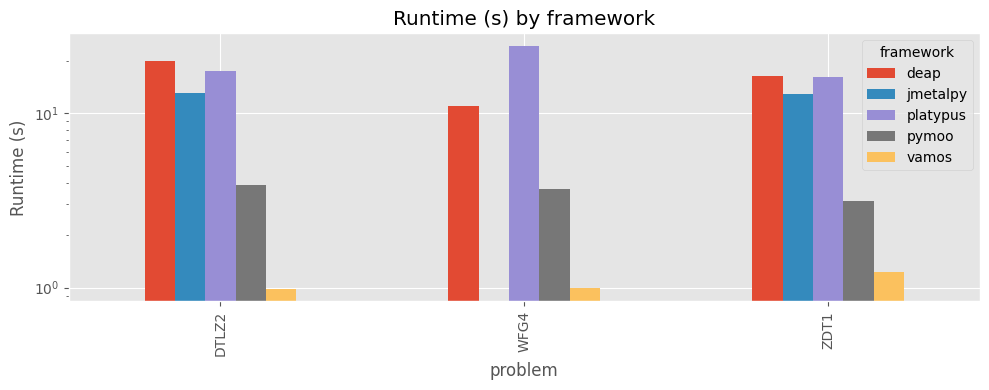

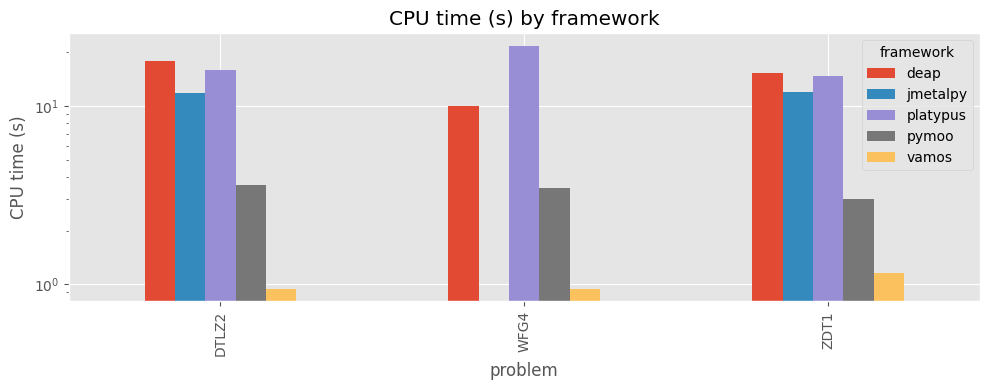

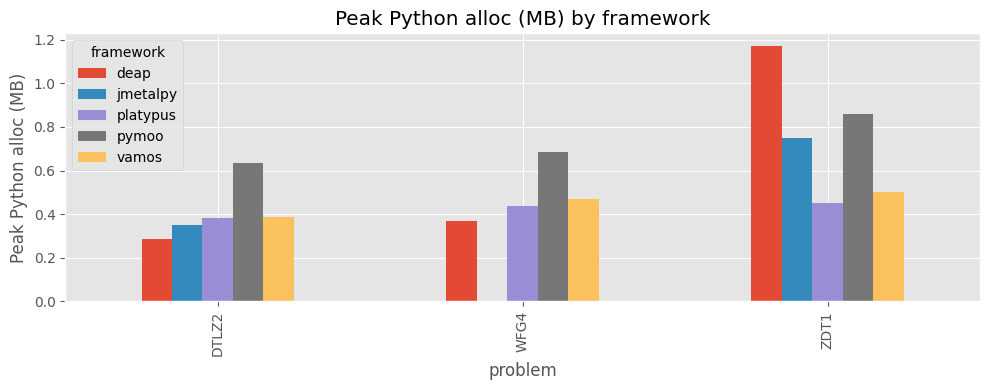

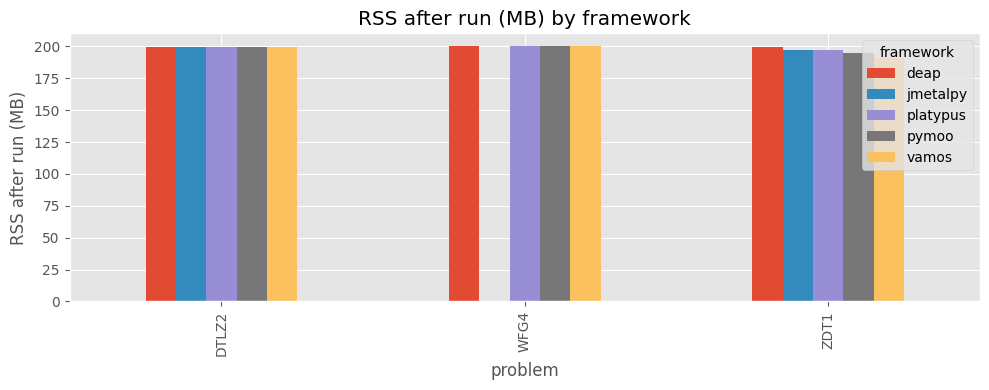

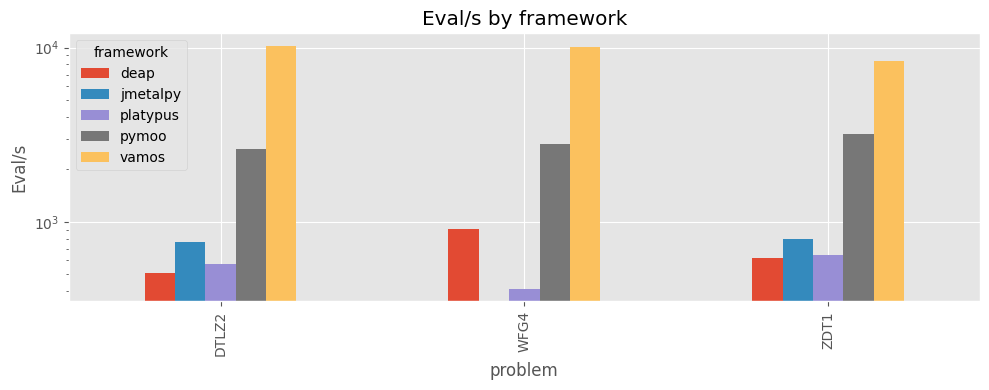

In [15]:
if not results_df.empty:
    metrics = [
        ("time_mean", "Runtime (s)", True),
        ("cpu_time_mean", "CPU time (s)", True),
        ("mem_mean", "Peak Python alloc (MB)", False),
        ("rss_mean", "RSS after run (MB)", False),
        ("evals_per_sec_mean", "Eval/s", True),
    ]
    for metric, label, logy in metrics:
        pivot = eff_summary.pivot(index="problem", columns="framework", values=metric)
        ax = pivot.plot(kind="bar", figsize=(10, 4))
        ax.set_ylabel(label)
        ax.set_title(f"{label} by framework")
        if logy:
            ax.set_yscale("log")
        plt.tight_layout()
        plt.show()


Metric: hv_norm | Friedman p-value: 0.4975


,algo_i,algo_j,statistic,p_value,p_holm
4,platypus,vamos,0.0,0.25,1.0
1,deap,pymoo,1.0,0.50,1.0
3,platypus,pymoo,1.0,0.50,1.0
2,deap,vamos,2.0,0.75,1.0
0,deap,platypus,2.0,1.00,1.0


,algo_i,algo_j,cliffs_delta
0,deap,platypus,0.000000
1,deap,pymoo,0.555556
2,deap,vamos,0.555556
3,platypus,pymoo,0.555556
4,platypus,vamos,1.000000
5,pymoo,vamos,0.111111


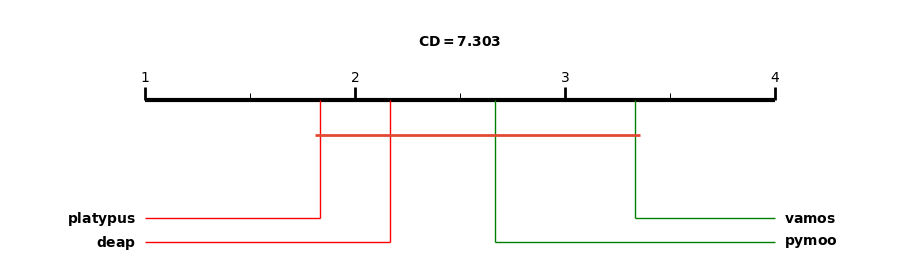

Metric: hv | Friedman p-value: 0.2366


,algo_i,algo_j,statistic,p_value,p_holm
2,deap,vamos,0.0,0.25,1.0
4,platypus,vamos,0.0,0.25,1.0
3,platypus,pymoo,1.0,0.50,1.0
1,deap,pymoo,1.0,0.50,1.0
5,pymoo,vamos,2.0,0.75,1.0


,algo_i,algo_j,cliffs_delta
0,deap,platypus,0.000000
1,deap,pymoo,-0.555556
2,deap,vamos,-0.777778
3,platypus,pymoo,-0.555556
4,platypus,vamos,-0.777778
5,pymoo,vamos,-0.111111


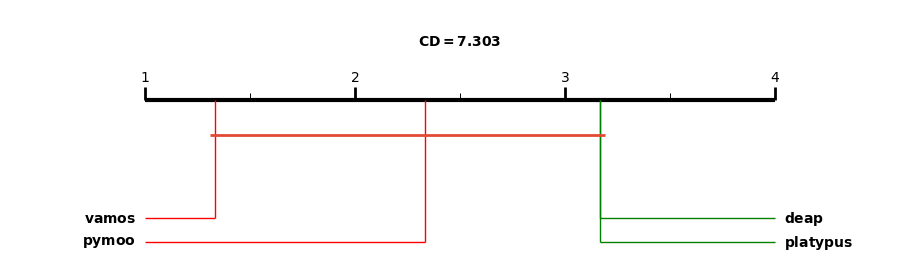

Metric: igd | Friedman p-value: 0.04673


,algo_i,algo_j,statistic,p_value,p_holm
1,deap,pymoo,0.0,0.25,1.0
2,deap,vamos,0.0,0.25,1.0
3,platypus,pymoo,0.0,0.25,1.0
4,platypus,vamos,0.0,0.25,1.0
0,deap,platypus,0.0,0.50,1.0


,algo_i,algo_j,cliffs_delta
0,deap,platypus,0.222222
1,deap,pymoo,-0.777778
2,deap,vamos,-0.777778
3,platypus,pymoo,-0.777778
4,platypus,vamos,-0.777778
5,pymoo,vamos,-0.111111


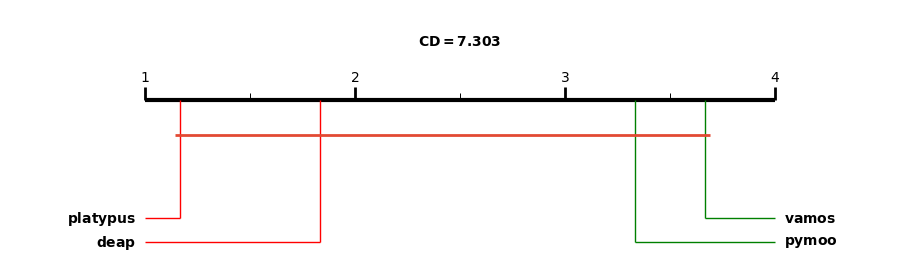

Metric: igd_plus | Friedman p-value: 0.5222


,algo_i,algo_j,statistic,p_value,p_holm
4,platypus,vamos,0.0,0.5,1.0
0,deap,platypus,2.0,1.0,1.0
2,deap,vamos,0.0,1.0,1.0
1,deap,pymoo,0.0,1.0,1.0
3,platypus,pymoo,2.0,1.0,1.0


,algo_i,algo_j,cliffs_delta
0,deap,platypus,-0.111111
1,deap,pymoo,0.111111
2,deap,vamos,0.111111
3,platypus,pymoo,0.111111
4,platypus,vamos,0.555556
5,pymoo,vamos,0.111111


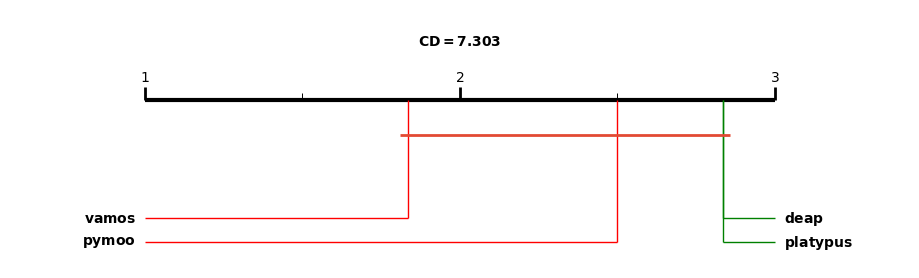

Metric: epsilon_add | Friedman p-value: 0.1527


,algo_i,algo_j,statistic,p_value,p_holm
1,deap,pymoo,0.0,0.25,1.0
3,platypus,pymoo,0.0,0.25,1.0
4,platypus,vamos,0.0,0.25,1.0
2,deap,vamos,1.0,0.50,1.0
5,pymoo,vamos,1.0,0.50,1.0


,algo_i,algo_j,cliffs_delta
0,deap,platypus,-0.444444
1,deap,pymoo,0.555556
2,deap,vamos,0.333333
3,platypus,pymoo,0.777778
4,platypus,vamos,0.777778
5,pymoo,vamos,0.111111


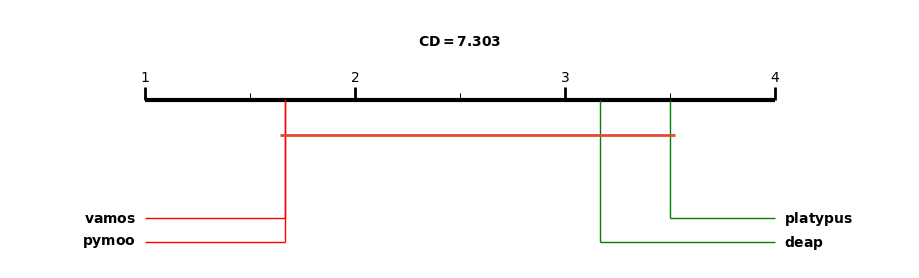

In [16]:
CD_STYLE = "saes"  # "saes" or "simple"

def holm_correction(p_values):
    p_values = np.asarray(p_values, dtype=float)
    m = len(p_values)
    order = np.argsort(p_values)
    adjusted = np.empty(m, dtype=float)
    for i, idx in enumerate(order):
        adjusted[idx] = min((m - i) * p_values[idx], 1.0)
    for i in range(m - 2, -1, -1):
        adjusted[order[i]] = max(adjusted[order[i]], adjusted[order[i + 1]])
    return adjusted

def cliffs_delta(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.size == 0 or b.size == 0:
        return np.nan
    diff = a[:, None] - b[None, :]
    greater = np.sum(diff > 0)
    less = np.sum(diff < 0)
    return float((greater - less) / (a.size * b.size))

def _saes_ranks(data, maximize):
    data = np.asarray(data, dtype=float)
    s = 0 if (maximize is False) else 1
    if data.ndim != 2:
        raise ValueError("CD plot data must be 2D.")
    ranks = np.ones(data.shape)
    for i in range(data.shape[0]):
        values, indices, rep = np.unique(
            (-1) ** s * np.sort((-1) ** s * data[i, :]),
            return_index=True,
            return_counts=True,
        )
        for j in range(data.shape[1]):
            pos = values == data[i, j]
            ranks[i, j] += indices[pos].item() + 0.5 * (rep[pos].item() - 1)
    return ranks

def _nemenyi_cd(alpha, num_alg, num_dataset):
    if num_dataset < 2:
        return np.nan
    try:
        from statsmodels.stats.libqsturng import qsturng

        q_alpha = qsturng(p=1 - alpha, r=num_alg, v=num_dataset - 1) / np.sqrt(2)
    except Exception:
        q_alpha = 2.569 if alpha == 0.05 else 2.343
    return q_alpha * np.sqrt(num_alg * (num_alg + 1) / (6.0 * num_dataset))

def plot_cd_saes_style(data, algo_names, maximize=True, alpha=0.05, width=9):
    data = np.asarray(data, dtype=float)
    if data.ndim != 2:
        raise ValueError("CD plot data must be 2D.")
    num_dataset, num_alg = data.shape
    cd = _nemenyi_cd(alpha, num_alg, num_dataset)

    rranks = _saes_ranks(data, maximize)
    avranks = np.mean(rranks, axis=0)
    indices = np.argsort(avranks).astype(int)
    avranks = avranks[indices]
    alg_names = np.asarray(algo_names)[indices]

    spoint = int(np.round(num_alg / 2.0))
    leftalg = avranks[:spoint]
    rightalg = avranks[spoint:]
    rows = int(np.ceil(num_alg / 2.0))

    highest = int(np.ceil(np.max(avranks)))
    lowest = int(np.floor(np.min(avranks)))
    span = max(1, highest - lowest)

    height = width * (0.8625 * (rows + 1) / 9)
    stop, sbottom, sleft, sright = 0.65, 0.1, 0.15, 0.85
    lline = sright - sleft

    fig = plt.figure(figsize=(width, height), facecolor="white")
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    ax.hlines(stop, sleft, sright, color="black", linewidth=3)
    for xi in range(highest - lowest + 1):
        ax.vlines(
            x=sleft + (lline * xi) / span,
            ymin=stop,
            ymax=stop + 0.05,
            color="black",
            linewidth=2,
        )
        ax.text(
            x=sleft + (lline * xi) / span,
            y=stop + 0.06,
            s=str(lowest + xi),
            ha="center",
            va="bottom",
        )
        if xi < highest - lowest:
            ax.vlines(
                x=sleft + (lline * (xi + 0.5)) / span,
                ymin=stop,
                ymax=stop + 0.025,
                color="black",
                linewidth=0.7,
            )

    vspace = 0.5 * (stop - sbottom) / (spoint + 1) if spoint else 0
    for i in range(spoint):
        x_pos = sleft + (lline * (leftalg[i] - lowest)) / span
        y_pos = sbottom + (spoint - 1 - i) * vspace
        ax.vlines(x=x_pos, ymin=y_pos, ymax=stop, color="red", linewidth=1)
        ax.hlines(y=y_pos, xmin=sleft, xmax=x_pos, color="red", linewidth=1)
        ax.text(
            x=sleft - 0.01,
            y=y_pos,
            s=f"$\\mathbf{{{alg_names[i]}}}$",
            ha="right",
            va="center",
        )

    vspace = 0.5 * (stop - sbottom) / (num_alg - spoint + 1) if num_alg - spoint else 0
    for i in range(num_alg - spoint):
        x_pos = sleft + (lline * (rightalg[i] - lowest)) / span
        y_pos = sbottom + i * vspace
        ax.vlines(x=x_pos, ymin=y_pos, ymax=stop, color="green", linewidth=1)
        ax.hlines(y=y_pos, xmin=x_pos, xmax=sright, color="green", linewidth=1)
        ax.text(
            x=sright + 0.01,
            y=y_pos,
            s=f"$\\mathbf{{{alg_names[spoint + i]}}}$",
            ha="left",
            va="center",
        )

    if np.isfinite(cd) and cd > 0:
        cd_span = (cd * lline) / span
        if sleft + cd_span <= sright:
            ax.hlines(y=stop + 0.2, xmin=sleft, xmax=sleft + cd_span, linewidth=1.5)
            ax.text(
                x=sleft + 0.5 * cd_span,
                y=stop + 0.21,
                s=f"CD={cd:.3f}",
                ha="center",
                va="bottom",
            )
        else:
            ax.text(
                x=(sleft + sright) / 2,
                y=stop + 0.2,
                s=f"$\\mathbf{{CD={cd:.3f}}}$",
                ha="center",
                va="bottom",
            )

    def _join_alg(avranks, num_alg, cd):
        sets = (-1) * np.ones((num_alg, 2))
        for i in range(num_alg):
            elements = np.where(
                np.logical_and(avranks - avranks[i] > 0, avranks - avranks[i] < cd)
            )[0]
            if elements.size > 0:
                sets[i, :] = [avranks[i], avranks[elements[-1]]]
        sets = np.delete(sets, np.where(sets[:, 0] < 0)[0], axis=0)
        if sets.size == 0:
            return sets
        group = sets[0, :]
        for i in range(1, sets.shape[0]):
            if sets[i - 1, 1] < sets[i, 1]:
                group = np.vstack((group, sets[i, :]))
        return group

    if np.isfinite(cd) and cd > 0:
        nonsig = _join_alg(avranks, num_alg, cd)
        if nonsig.size == 0:
            left_lines = np.array([])
            right_lines = np.array([])
        elif nonsig.ndim == 2:
            if nonsig.shape[0] == 2:
                left_lines = np.reshape(nonsig[0, :], (1, 2))
                right_lines = np.reshape(nonsig[1, :], (1, 2))
            else:
                left_lines = nonsig[: int(np.round(nonsig.shape[0] / 2.0)), :]
                right_lines = nonsig[int(np.round(nonsig.shape[0] / 2.0)) :, :]
        else:
            left_lines = np.reshape(nonsig, (1, nonsig.shape[0]))

        if nonsig.size > 0:
            vspace = 0.5 * (stop - sbottom) / (left_lines.shape[0] + 1)
            for i in range(left_lines.shape[0]):
                ax.hlines(
                    y=stop - (i + 1) * vspace,
                    xmin=sleft + lline * (left_lines[i, 0] - lowest - 0.025) / span,
                    xmax=sleft + lline * (left_lines[i, 1] - lowest + 0.025) / span,
                    linewidth=2,
                )

            if nonsig.ndim == 2 and right_lines.size > 0:
                vspace = 0.5 * (stop - sbottom) / (left_lines.shape[0])
                for i in range(right_lines.shape[0]):
                    ax.hlines(
                        y=stop - (i + 1) * vspace,
                        xmin=sleft + lline * (right_lines[i, 0] - lowest - 0.025) / span,
                        xmax=sleft + lline * (right_lines[i, 1] - lowest + 0.025) / span,
                        linewidth=2,
                    )

    plt.show()

def stats_table(df, metric, higher_is_better):
    pivot = df.pivot_table(index="problem", columns="framework", values=metric, aggfunc="mean")
    pivot = pivot.dropna(axis=1, how="any")
    if pivot.shape[1] < 3:
        print("Need at least 3 frameworks with full coverage for Friedman test.")
        return None, None, None, None
    scores = pivot.to_numpy()
    fried = friedman_test(scores, higher_is_better=higher_is_better)
    wilc = pairwise_wilcoxon(scores, pivot.columns, higher_is_better=higher_is_better)
    wilc_df = pd.DataFrame([w.__dict__ for w in wilc]).sort_values("p_value")
    wilc_df["p_holm"] = holm_correction(wilc_df["p_value"].to_numpy())

    effects = []
    names = list(pivot.columns)
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            delta = cliffs_delta(scores[:, i], scores[:, j])
            effects.append({"algo_i": names[i], "algo_j": names[j], "cliffs_delta": delta})
    effects_df = pd.DataFrame(effects)
    return pivot, fried, wilc_df, effects_df

if not results_df.empty:
    metric_specs = [
        ("hv_norm", True),
        ("hv", True),
        ("igd", False),
        ("igd_plus", False),
        ("epsilon_add", False),
    ]
    for metric, higher_is_better in metric_specs:
        if metric not in results_df.columns or results_df[metric].isna().all():
            continue
        pivot, fried, wilc_df, effects_df = stats_table(results_df, metric, higher_is_better)
        if fried is None:
            continue
        print(f"Metric: {metric} | Friedman p-value: {fried.p_value:.4g}")
        display(wilc_df.head())
        display(effects_df)
        if CD_STYLE == "saes":
            plot_cd_saes_style(pivot.to_numpy(), pivot.columns, maximize=higher_is_better)
        else:
            plot_critical_distance(fried.avg_ranks, pivot.columns, n_problems=len(pivot), show=True)


## Quality over time and time-to-target (optional)

This section runs a multi-budget sweep to approximate quality over time curves.
Set RUN_QOT=True to enable.


In [17]:
qot_df = pd.DataFrame()
if RUN_QOT:
    qot_results = []
    for spec in PROBLEMS:
        if spec["key"] not in REF_FRONTS:
            continue
        ref = REF_FRONTS[spec["key"]]
        for framework in FRAMEWORKS:
            runner = RUNNERS.get(framework)
            if runner is None:
                continue
            for seed in QOT_SEEDS:
                for frac in QOT_BUDGETS:
                    max_evals = max(1, int(MAX_EVALS * frac))
                    try:
                        F, elapsed, peak, cpu_time, rss_mb, rss_delta = run_with_profile(
                            runner,
                            spec,
                            seed,
                            max_evals=max_evals,
                            pop_size=POP_SIZE,
                        )
                    except Exception as exc:
                        print(f"QOT skip {framework} {spec['label']} seed {seed}: {exc}")
                        continue
                    if F is None or len(F) == 0:
                        continue
                    metrics = compute_metrics(F, ref)
                    qot_results.append(
                        {
                            "framework": framework,
                            "problem": spec["label"],
                            "seed": seed,
                            "budget_frac": frac,
                            "n_eval": max_evals,
                            "time_s": elapsed,
                            "hv": metrics["hv"],
                            "hv_norm": metrics["hv_norm"],
                            "igd": metrics["igd"],
                        }
                    )
    qot_df = pd.DataFrame(qot_results)
    qot_df.head()
else:
    print("Set RUN_QOT=True to run this section.")


[2025-12-23 20:59:00,220] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-23 20:59:00,231] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-12-23 20:59:00,234] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-12-23 20:59:00,235] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-12-23 20:59:04,295] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-12-23 20:59:04,316] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-23 20:59:04,325] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-12-23 20:59:04,327] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-12-23 20:59:04,329] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-12-23 20:59:11,859] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-12-23 20:59:11,883] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-12-23 20:59:11,891] [jm

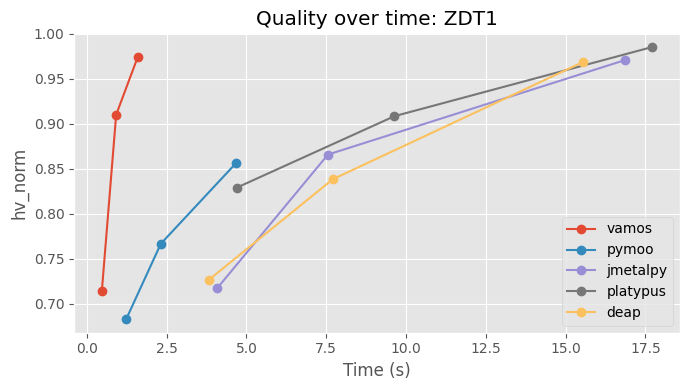

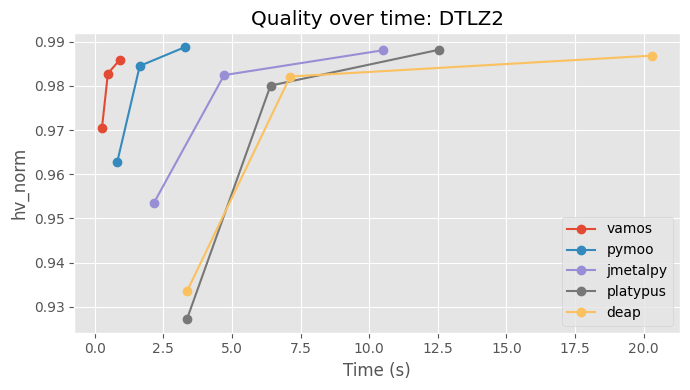

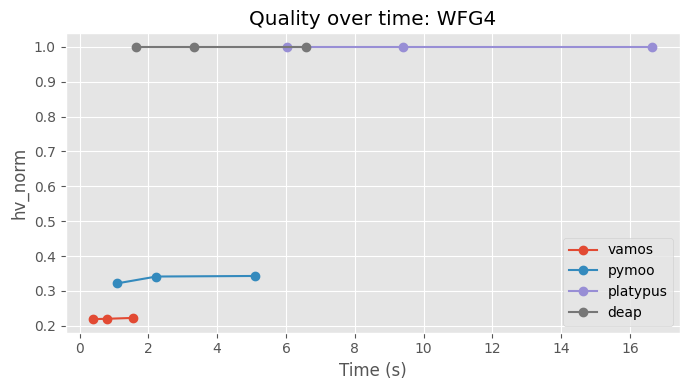

In [18]:
if RUN_QOT and not qot_df.empty:
    metric = "hv_norm" if qot_df["hv_norm"].notna().any() else "hv"
    for problem in qot_df["problem"].unique():
        sub = qot_df[qot_df["problem"] == problem]
        fig, ax = plt.subplots(figsize=(7, 4))
        for framework in sub["framework"].unique():
            group = (
                sub[sub["framework"] == framework]
                .groupby("budget_frac")
                .agg(metric=(metric, "mean"), time_s=("time_s", "mean"))
                .sort_values("time_s")
            )
            ax.plot(group["time_s"], group["metric"], marker="o", label=framework)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(metric)
        ax.set_title(f"Quality over time: {problem}")
        ax.legend()
        plt.tight_layout()
        plt.show()

    targets = {}
    max_frac = max(QOT_BUDGETS)
    for problem in qot_df["problem"].unique():
        full = qot_df[(qot_df["problem"] == problem) & (qot_df["budget_frac"] == max_frac)]
        best = full.groupby("framework")[metric].mean().max()
        targets[problem] = 0.95 * best

    ttt_rows = []
    for (problem, framework), group in qot_df.groupby(["problem", "framework"]):
        target = targets.get(problem, np.nan)
        if np.isnan(target):
            continue
        group = group.sort_values("time_s")
        hits = group[group[metric] >= target]
        ttt = hits["time_s"].min() if not hits.empty else np.nan
        ttt_rows.append({"problem": problem, "framework": framework, "metric": metric, "target": target, "time_to_target_s": ttt})

    ttt_df = pd.DataFrame(ttt_rows)
    ttt_df


## Scalability sweep (n_var, n_obj, pop size)

Set RUN_SCALING=True to execute. Default is VAMOS-only to keep runtime reasonable.


In [19]:
scaling_df = pd.DataFrame()
if RUN_SCALING:
    scaling_results = []
    for n_obj in SCALING_N_OBJS:
        for n_var in SCALING_N_VARS:
            if n_var <= n_obj:
                continue
            spec = {
                "key": "dtlz2",
                "label": f"DTLZ2-{n_var}v-{n_obj}o",
                "n_var": n_var,
                "n_obj": n_obj,
            }
            for pop in SCALING_POP_SIZES:
                for framework in SCALING_FRAMEWORKS:
                    runner = RUNNERS.get(framework)
                    if runner is None:
                        continue
                    try:
                        F, elapsed, peak, cpu_time, rss_mb, rss_delta = run_with_profile(
                            runner,
                            spec,
                            SCALING_SEED,
                            max_evals=SCALING_MAX_EVALS,
                            pop_size=pop,
                        )
                    except Exception as exc:
                        print(f"Scaling skip {framework} {spec['label']} pop {pop}: {exc}")
                        continue
                    scaling_results.append(
                        {
                            "framework": framework,
                            "problem": spec["label"],
                            "n_var": n_var,
                            "n_obj": n_obj,
                            "pop_size": pop,
                            "n_eval": SCALING_MAX_EVALS,
                            "time_s": elapsed,
                            "cpu_time_s": cpu_time,
                            "mem_mb": peak,
                            "rss_mb": rss_mb,
                        }
                    )
    scaling_df = pd.DataFrame(scaling_results)
    scaling_df
else:
    print("Set RUN_SCALING=True to run this section.")


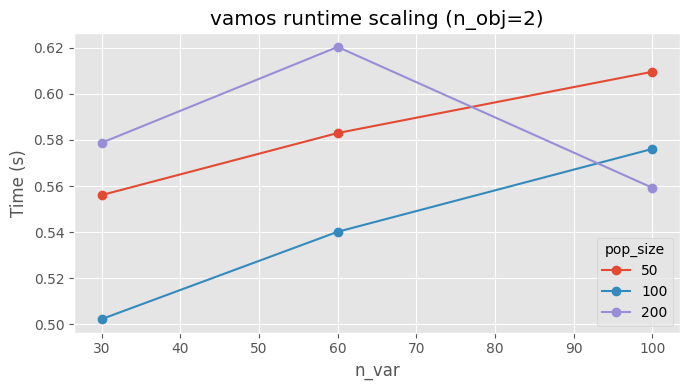

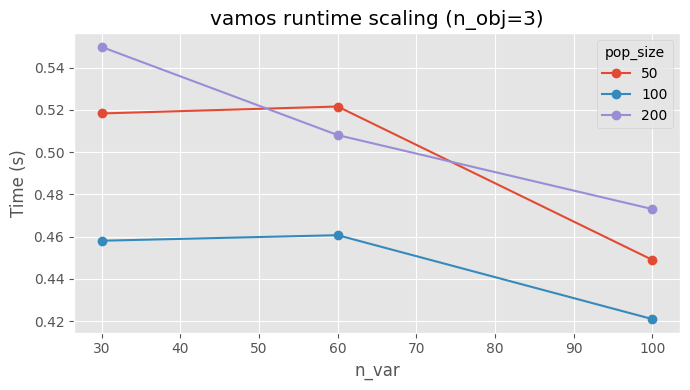

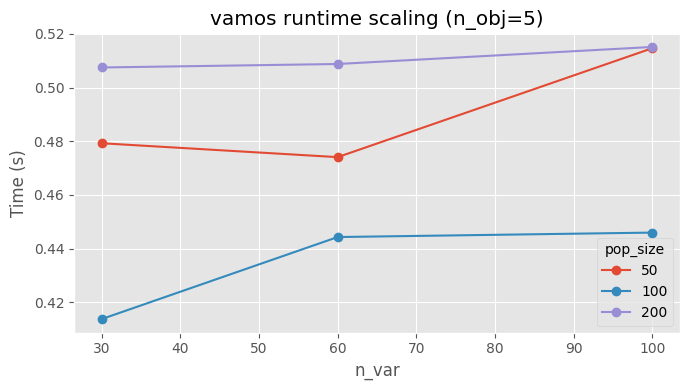

In [20]:
if RUN_SCALING and not scaling_df.empty:
    scaling_df = scaling_df.copy()
    scaling_df["evals_per_sec"] = scaling_df["n_eval"] / scaling_df["time_s"]

    for framework in scaling_df["framework"].unique():
        sub = scaling_df[scaling_df["framework"] == framework]
        for n_obj in sorted(sub["n_obj"].unique()):
            sub_obj = sub[sub["n_obj"] == n_obj]
            pivot = sub_obj.pivot_table(index="n_var", columns="pop_size", values="time_s", aggfunc="mean")
            ax = pivot.plot(kind="line", marker="o", figsize=(7, 4))
            ax.set_title(f"{framework} runtime scaling (n_obj={n_obj})")
            ax.set_xlabel("n_var")
            ax.set_ylabel("Time (s)")
            plt.tight_layout()
            plt.show()


## Performance claims: vectorized vs baseline evaluation


In [21]:
EVAL_SAMPLES = 5000
perf_problem = ZDT1(n_var=30)
rng = np.random.default_rng(0)
X_eval = rng.uniform(perf_problem.xl, perf_problem.xu, size=(EVAL_SAMPLES, perf_problem.n_var))

def eval_vectorized():
    F = np.empty((X_eval.shape[0], perf_problem.n_obj))
    perf_problem.evaluate(X_eval, {"F": F})
    return F

def eval_baseline():
    F = np.empty((X_eval.shape[0], perf_problem.n_obj))
    for i in range(X_eval.shape[0]):
        perf_problem.evaluate(X_eval[i:i+1], {"F": F[i:i+1]})
    return F

_, vec_time, vec_mem, vec_cpu, vec_rss, vec_rss_delta = run_with_profile(lambda: eval_vectorized())
_, base_time, base_mem, base_cpu, base_rss, base_rss_delta = run_with_profile(lambda: eval_baseline())

pd.DataFrame(
    [
        {
            "mode": "vectorized",
            "time_s": vec_time,
            "cpu_time_s": vec_cpu,
            "mem_mb": vec_mem,
            "rss_mb": vec_rss,
            "rss_mb_delta": vec_rss_delta,
        },
        {
            "mode": "baseline_loop",
            "time_s": base_time,
            "cpu_time_s": base_cpu,
            "mem_mb": base_mem,
            "rss_mb": base_rss,
            "rss_mb_delta": base_rss_delta,
        },
    ]
)


,mode,time_s,cpu_time_s,mem_mb,rss_mb,rss_mb_delta
0,vectorized,0.000262,0.00000,0.191345,225.472656,0.0
1,baseline_loop,0.217654,0.21875,0.078433,225.472656,0.0


## Performance claims: VAMOS backends (NumPy / Numba / MooCore)


In [22]:
available_engines = []
for name in KERNELS:
    try:
        resolve_kernel(name)
        available_engines.append(name)
    except Exception as exc:
        print(f"Skipping {name}: {exc}")

def run_backend(engine):
    problem = ZDT1(n_var=30)
    cfg = NSGAIIConfig.default(pop_size=POP_SIZE, n_var=problem.n_var, engine=engine)
    return optimize(
        OptimizeConfig(
            problem=problem,
            algorithm="nsgaii",
            algorithm_config=cfg,
            termination=("n_eval", MAX_EVALS),
            seed=42,
            engine=engine,
        )
    )

backend_results = []
for engine in available_engines:
    if engine == "numba":
        _ = run_backend(engine)  # warmup for JIT
    _, elapsed, peak, cpu_time, rss_mb, rss_delta = run_with_profile(lambda e=engine: run_backend(e))
    backend_results.append(
        {"engine": engine, "time_s": elapsed, "mem_mb": peak, "rss_mb": rss_mb, "cpu_time_s": cpu_time}
    )

backend_df = pd.DataFrame(backend_results)
print("\n=== LaTeX Table ===\n")
print(backend_df.to_latex(index=False, float_format="%.4f", caption="Backend Performance Comparison", label="tab:backend_perf"))
print("===================\n")
backend_df


,engine,time_s,mem_mb,rss_mb,cpu_time_s
0,numpy,0.997823,0.509853,233.917969,0.93750
1,numba,0.531096,0.260586,264.046875,0.50000
2,moocore,0.675716,0.334389,264.300781,0.65625


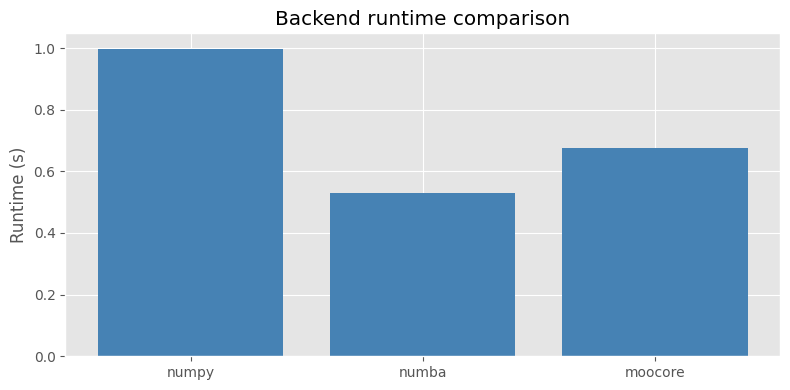

In [23]:
if not backend_df.empty and "numpy" in backend_df["engine"].values:
    numpy_time = backend_df.loc[backend_df["engine"] == "numpy", "time_s"].iloc[0]
    backend_df["speedup_vs_numpy"] = numpy_time / backend_df["time_s"]

if not backend_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(backend_df["engine"], backend_df["time_s"], color="steelblue")
    ax.set_ylabel("Runtime (s)")
    ax.set_title("Backend runtime comparison")
    plt.tight_layout()
    plt.show()


### QOT Visualization

Visualizing the quality metrics over time.

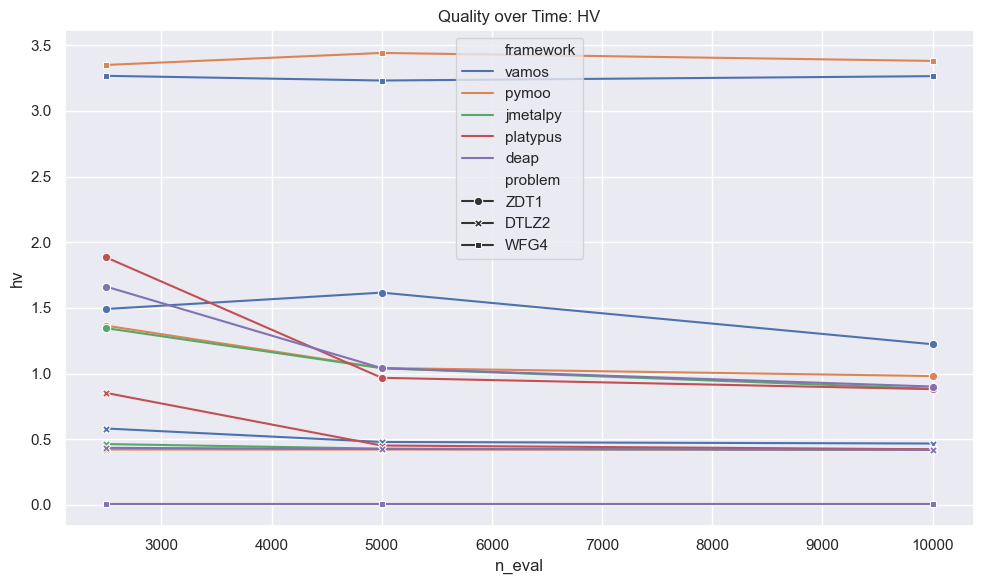

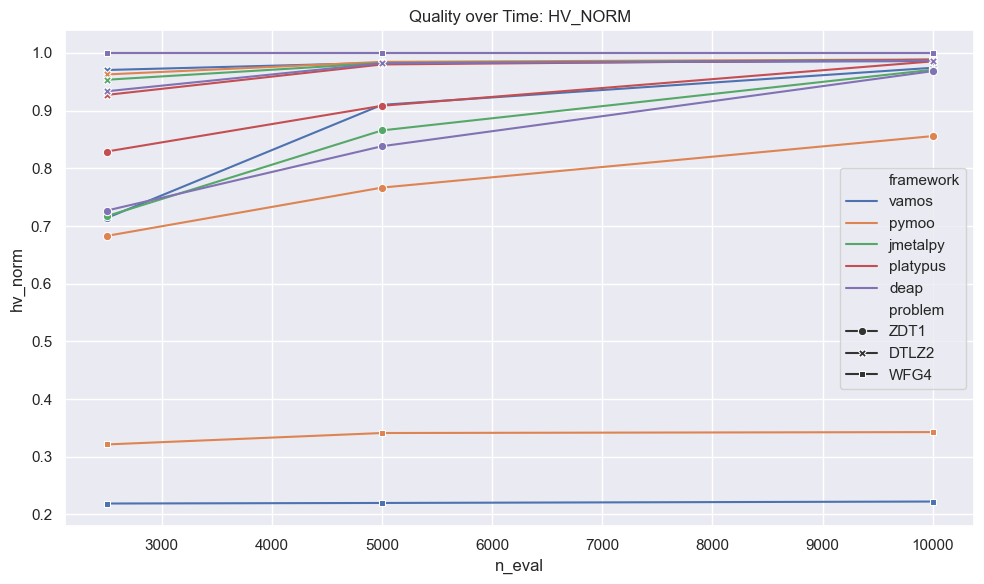

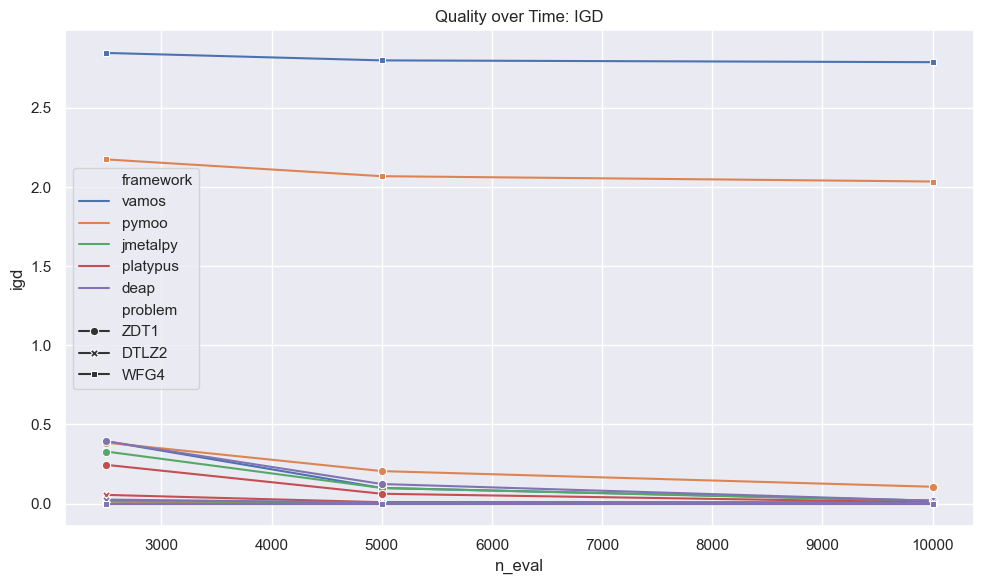

In [24]:
if not qot_df.empty:
    import seaborn as sns
    sns.set_theme(style="darkgrid")
    
    metrics_to_plot = ["hv", "hv_norm", "igd"]
    for metric in metrics_to_plot:
        if metric in qot_df.columns:
            plt.figure(figsize=(10, 6))
            sns.lineplot(
                data=qot_df, 
                x="n_eval", 
                y=metric, 
                hue="framework", 
                style="problem", 
                markers=True,
                dashes=False
            )
            plt.title(f"Quality over Time: {metric.upper()}")
            plt.tight_layout()
            plt.show()

## Scaling Analysis (optional)

Benchmark runtime and memory usage as a function of problem scale (number of variables).
Set RUN_SCALING=True to enable.

Running scaling analysis...
  Scaling problem: zdt1_d30
  Scaling problem: zdt1_d60
  Scaling problem: zdt1_d100


,framework,n_var,time_s,peak_mem_mb,rss_mb
0,vamos,30,0.458051,0.495889,277.132812
1,vamos,60,0.489011,0.687731,277.546875
2,vamos,100,0.494219,0.949260,277.929688


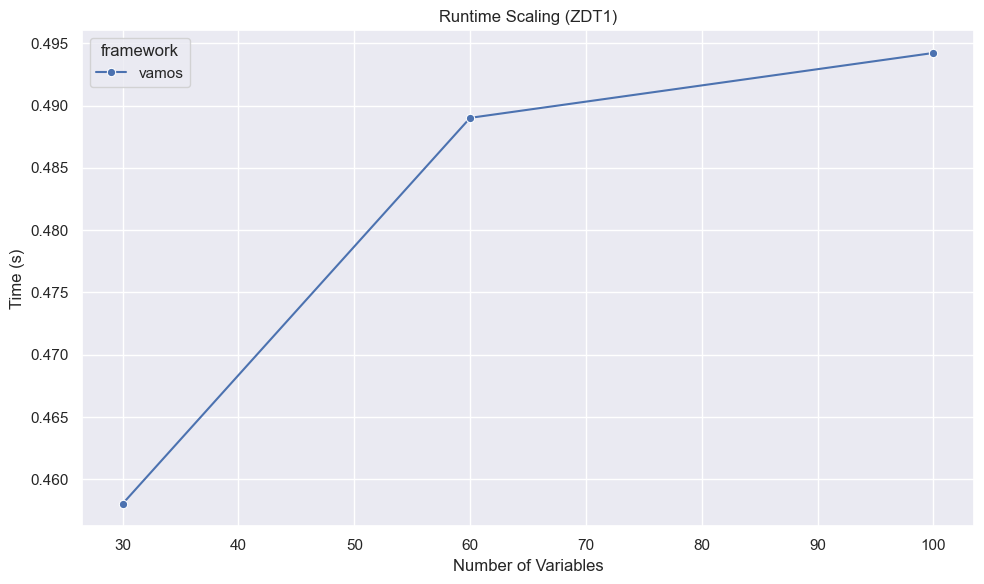

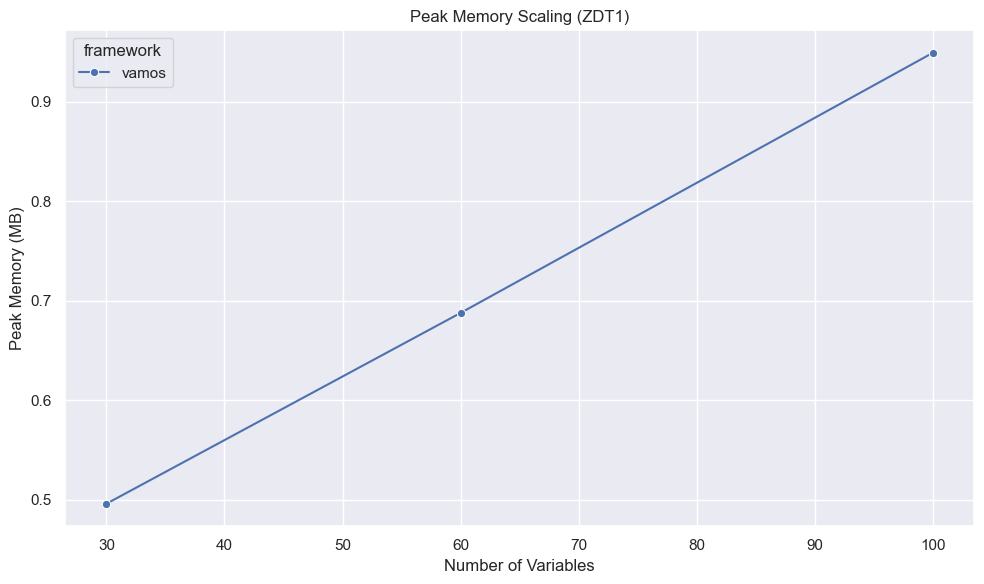

In [25]:
scaling_df = pd.DataFrame()
if RUN_SCALING:
    print("Running scaling analysis...")
    # Clean scaling specs - focus on ZDT1 for scaling variables
    scaling_key = "zdt1"
    
    scaling_specs = []
    # Scales: 
    for n in SCALING_N_VARS:
        s = {"key": scaling_key, "n_obj": 2, "n_var": n, "label": f"{scaling_key}_d{n}"}
        scaling_specs.append(s)
        
    scaling_results = []
    for spec in scaling_specs:
        problem_label = spec["label"]
        print(f"  Scaling problem: {problem_label}")
        
        for framework in SCALING_FRAMEWORKS:
            runner = RUNNERS.get(framework)
            if runner is None:
                continue
            
            seed = SCALING_SEED
            try:
                # We care about time and memory here
                F, elapsed, peak, cpu_time, rss_mb, rss_delta = run_with_profile(
                    runner,
                    spec,
                    seed,
                    max_evals=SCALING_MAX_EVALS,
                    pop_size=POP_SIZE # Or use SCALING_POP_SIZES if we want to scale that too
                )
                
                scaling_results.append({
                    "framework": framework,
                    "n_var": spec["n_var"],
                    "time_s": elapsed,
                    "peak_mem_mb": peak,
                    "rss_mb": rss_mb
                })
            except Exception as e:
                print(f"Scaling fail {framework} {problem_label}: {e}")

    scaling_df = pd.DataFrame(scaling_results)
    if not scaling_df.empty:
        display(scaling_df)
        
        # Plot Time Scaling
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=scaling_df, x="n_var", y="time_s", hue="framework", marker="o")
        plt.title("Runtime Scaling (ZDT1)")
        plt.xlabel("Number of Variables")
        plt.ylabel("Time (s)")
        # plt.yscale("log")
        plt.tight_layout()
        plt.show()
        
        # Plot Memory Scaling
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=scaling_df, x="n_var", y="peak_mem_mb", hue="framework", marker="o")
        plt.title("Peak Memory Scaling (ZDT1)")
        plt.xlabel("Number of Variables")
        plt.ylabel("Peak Memory (MB)")
        plt.tight_layout()
        plt.show()
else:
    print("Set RUN_SCALING=True to run this section.")